## Introduction

Human Activity Recognition (HAR) is an area of machine learning that focuses on automatically identifying physical activities performed by individuals using data collected from sensors. Modern smartphones, equipped with accelerometers and gyroscopes, generate detailed motion data that can be analyzed to classify activities such as walking, sitting, standing, or lying down.  

In this project, we use the **Human Activity Recognition Using Smartphones** dataset — collected from 30 volunteers performing six different activities while carrying a smartphone on their waist. Each record in the dataset represents a 2.56-second window of sensor readings and includes a **561-feature vector** extracted from both the time and frequency domains.  

The original experiment and data collection process are demonstrated in this short video:  
[Watch on YouTube](http://www.youtube.com/watch?v=XOEN9W05_4A)



## Objective

The primary goals of this project are to:

- Conduct a thorough **Exploratory Data Analysis (EDA)** to understand the structure, relationships, and quality of the dataset.  
- Identify correlations, feature variances, and potential redundancies in the feature space.  
- Train and evaluate a **supervised machine learning model** using different algorithms to predict the performed activity from the smartphone sensor data.  
- Assess the model’s performance using appropriate evaluation metrics and interpret the most significant contributing features.

Ultimately, this project aims to showcase how classical machine learning methods can effectively interpret sensor data for **real-world applications** such as health monitoring, fitness tracking, and context-aware intelligent systems.
n **health monitoring**, **fitness tracking**, and **smart environments**.



## Dataset Overview

The features describe various statistical and frequency-based properties derived from the smartphone’s sensors:
- **Accelerometer features**  
  - Total acceleration (gravity + body motion)  
  - Body acceleration (after separating gravitational effects with a low-pass Butterworth filter)
- **Gyroscope features**  
  - Angular velocity along X, Y, Z axes, measured in radians per second
- **Derived signals and transformations**  
  - Jerk signals (rate of change of acceleration or angular velocity)  
  - Magnitude signals computed using the Euclidean norm of triaxial components  
  - Fast Fourier Transform (FFT) features representing the frequency content of signals

From these processed signals, multiple statistical descriptors were calculated, including:
- **Mean**, **Standard Deviation**, **Median Absolute Deviation (MAD)**, **Max/Min**, **Energy**, **Entropy**, **Correlation**, and **Signal Magnitude Area (SMA)**  
- **Frequency-domain coefficients** such as **meanFreq()**, **skewness()**, and **kurtosis()**
- **Angles** between vectors (e.g., between acceleration mean and gravity direction)

All features were **normalized** and **bounded between [-1, 1]** to ensure consistency across subjects and activities.

Each record therefore includes:
- A 561-dimensional numeric feature vector  
- An activity label (`1–6`, corresponding to one of the six actions)  
- A subject identifier (`1–30`)

### Importing Libraries & Loading Dataset

Before any data exploration or modeling, we begin by importing the required Python libraries and loading the dataset into our environment.

This project uses the **Human Activity Recognition Using Smartphones** dataset, which contains **561 features** derived from accelerometer and gyroscope signals recorded at 50 Hz. Each sample corresponds to a 2.56 s window of sensor readings, labeled with one of six activities.

The following steps are performed here:
1. Import key libraries for data handling, visualization, and analysis (`pandas`, `numpy`, `matplotlib`, `seaborn`, `scipy`).
2. Load the dataset files for both **training** and **testing** partitions.
3. Read feature names and activity labels from the metadata files.
4. Handle duplicate feature names by adding numerical suffixes for uniqueness.
5. Map activity IDs to their descriptive labels (e.g., *1 → WALKING*).
6. Display basic dataset information to confirm structure and consistency.


In [2]:
# Import the dataset

import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats


# Base path to the dataset
base_path = r"C:\Users\narek.pirumyan\Desktop\IAE\2025\AI ML\Implementations\HAR\HAR with Smartphone\UCI HAR Dataset\UCI HAR Dataset"

#  Load features and activity labels 
features = pd.read_csv(os.path.join(base_path, 'features.txt'), sep=r'\s+', header=None)
feature_names = features[1].values

# Handle duplicate feature names by adding suffixes
unique_feature_names = []
name_counts = {}
for name in feature_names:
    if name in name_counts:
        name_counts[name] += 1
        unique_feature_names.append(f"{name}_{name_counts[name]}")
    else:
        name_counts[name] = 0
        unique_feature_names.append(name)

# Load activity labels
activity_labels = pd.read_csv(os.path.join(base_path, 'activity_labels.txt'), sep=r'\s+', header=None, index_col=0)
activity_labels_dict = activity_labels[1].to_dict()

# Load train and test data 
X_train = pd.read_csv(os.path.join(base_path, 'train', 'X_train.txt'), sep=r'\s+', header=None, names=unique_feature_names)
y_train = pd.read_csv(os.path.join(base_path, 'train', 'y_train.txt'), sep=r'\s+', header=None)[0]
subject_train = pd.read_csv(os.path.join(base_path, 'train', 'subject_train.txt'), sep=r'\s+', header=None)[0]

X_test = pd.read_csv(os.path.join(base_path, 'test', 'X_test.txt'), sep=r'\s+', header=None, names=unique_feature_names)
y_test = pd.read_csv(os.path.join(base_path, 'test', 'y_test.txt'), sep=r'\s+', header=None)[0]
subject_test = pd.read_csv(os.path.join(base_path, 'test', 'subject_test.txt'), sep=r'\s+', header=None)[0]

#  Map activity numbers to labels 
y_train = y_train.map(activity_labels_dict)
y_test = y_test.map(activity_labels_dict)

#  Display dataset summary
print("Data successfully loaded!\n")
print(f"Training set: {X_train.shape} | Test set: {X_test.shape}")
print(f"Features: {len(unique_feature_names)} (Unique names ensured)")
print(f"Activities: {activity_labels_dict}\n")

print("First few rows of X_train:")
display(X_train.head())

print("\nLabel distribution in training set:")
display(y_train.value_counts())



Data successfully loaded!

Training set: (7352, 561) | Test set: (2947, 561)
Features: 561 (Unique names ensured)
Activities: {1: 'WALKING', 2: 'WALKING_UPSTAIRS', 3: 'WALKING_DOWNSTAIRS', 4: 'SITTING', 5: 'STANDING', 6: 'LAYING'}

First few rows of X_train:


,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-meanFreq(),fBodyBodyGyroJerkMag-skewness(),fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)"
0,0.288585,-0.020294,-0.132905,-0.995279,-0.983111,-0.913526,-0.995112,-0.983185,-0.923527,-0.934724,...,-0.074323,-0.298676,-0.710304,-0.112754,0.030400,-0.464761,-0.018446,-0.841247,0.179941,-0.058627
1,0.278419,-0.016411,-0.123520,-0.998245,-0.975300,-0.960322,-0.998807,-0.974914,-0.957686,-0.943068,...,0.158075,-0.595051,-0.861499,0.053477,-0.007435,-0.732626,0.703511,-0.844788,0.180289,-0.054317
2,0.279653,-0.019467,-0.113462,-0.995380,-0.967187,-0.978944,-0.996520,-0.963668,-0.977469,-0.938692,...,0.414503,-0.390748,-0.760104,-0.118559,0.177899,0.100699,0.808529,-0.848933,0.180637,-0.049118
3,0.279174,-0.026201,-0.123283,-0.996091,-0.983403,-0.990675,-0.997099,-0.982750,-0.989302,-0.938692,...,0.404573,-0.117290,-0.482845,-0.036788,-0.012892,0.640011,-0.485366,-0.848649,0.181935,-0.047663
4,0.276629,-0.016570,-0.115362,-0.998139,-0.980817,-0.990482,-0.998321,-0.979672,-0.990441,-0.942469,...,0.087753,-0.351471,-0.699205,0.123320,0.122542,0.693578,-0.615971,-0.847865,0.185151,-0.043892



Label distribution in training set:


0
LAYING                1407
STANDING              1374
SITTING               1286
WALKING               1226
WALKING_UPSTAIRS      1073
WALKING_DOWNSTAIRS     986
Name: count, dtype: int64

#### Observations

- The training dataset contains **7,352 samples** and the test dataset **2,947 samples**, each with **561 features**.
- All feature names have been successfully loaded and made unique to prevent column conflicts.
- The activity labels were correctly mapped to human-readable categories:
  `WALKING`, `WALKING_UPSTAIRS`, `WALKING_DOWNSTAIRS`, `SITTING`, `STANDING`, and `LAYING`.
- Each feature is a continuous variable (`float64`), already normalized within `[-1, 1]`.
- The label distribution appears balanced across all activity classes, which is ideal for model training.


### Data Integrity Checks

Data integrity is a fundamental aspect of data analysis and represents the first step in our exploratory data analysis workflow. Before examining distributions, feature properties, or relationships, it is crucial to verify that the dataset is complete and free from missing values that could adversely affect model performance or lead to incorrect conclusions.

In this section, we:
1. Perform a comprehensive check for missing data across all 561 features in both training and testing datasets.
2. Verify that activity labels contain no missing values.
3. Confirm data completeness to ensure reliability of subsequent analyses and modeling steps.

Missing values can arise from sensor failures, data collection errors, or preprocessing issues. Identifying them early helps determine whether imputation techniques are needed and ensures the quality of our exploratory findings.


In [3]:
# Missing Values Analysis

print("=" * 60)
print("MISSING VALUES ANALYSIS")
print("=" * 60)

# Check for missing values
train_missing = X_train.isnull().sum().sum()
test_missing = X_test.isnull().sum().sum()
y_train_missing = y_train.isnull().sum()
y_test_missing = y_test.isnull().sum()

print(f"Missing values in X_train: {train_missing}")
print(f"Missing values in X_test: {test_missing}")
print(f"Missing values in y_train: {y_train_missing}")
print(f"Missing values in y_test: {y_test_missing}")


MISSING VALUES ANALYSIS
Missing values in X_train: 0
Missing values in X_test: 0
Missing values in y_train: 0
Missing values in y_test: 0


#### Observations

- The dataset contains **no missing values** in both training and test sets, ensuring data completeness.
- All **561 features** and activity labels are fully populated, which indicates high-quality data collection and preprocessing.
- This clean dataset allows us to proceed with confidence to exploratory analysis and modeling without the need for imputation techniques.


### Dataset Overview & Label Distribution

Understanding the distribution of activity labels across the dataset is essential for assessing class balance and ensuring that our models can learn effectively from all activity types. Class imbalance can lead to biased predictions where the model favors majority classes.

In this section, we analyze:
1. The distribution of each activity in both training and test sets.
2. Whether the distributions are balanced across all six activities.
3. The balance between different subjects (people) and their activity participation.
4. Whether all subjects performed all activities (coverage analysis).

A well-balanced dataset across activities and subjects ensures that the model learns generalizable patterns rather than subject-specific or activity-biased characteristics.

ACTIVITY DISTRIBUTION ANALYSIS
Training Set Distribution:
  LAYING: 1,407 samples (19.1%)
  SITTING: 1,286 samples (17.5%)
  STANDING: 1,374 samples (18.7%)
  WALKING: 1,226 samples (16.7%)
  WALKING_DOWNSTAIRS: 986 samples (13.4%)
  WALKING_UPSTAIRS: 1,073 samples (14.6%)

Test Set Distribution:
  LAYING: 537 samples (18.2%)
  SITTING: 491 samples (16.7%)
  STANDING: 532 samples (18.1%)
  WALKING: 496 samples (16.8%)
  WALKING_DOWNSTAIRS: 420 samples (14.3%)
  WALKING_UPSTAIRS: 471 samples (16.0%)


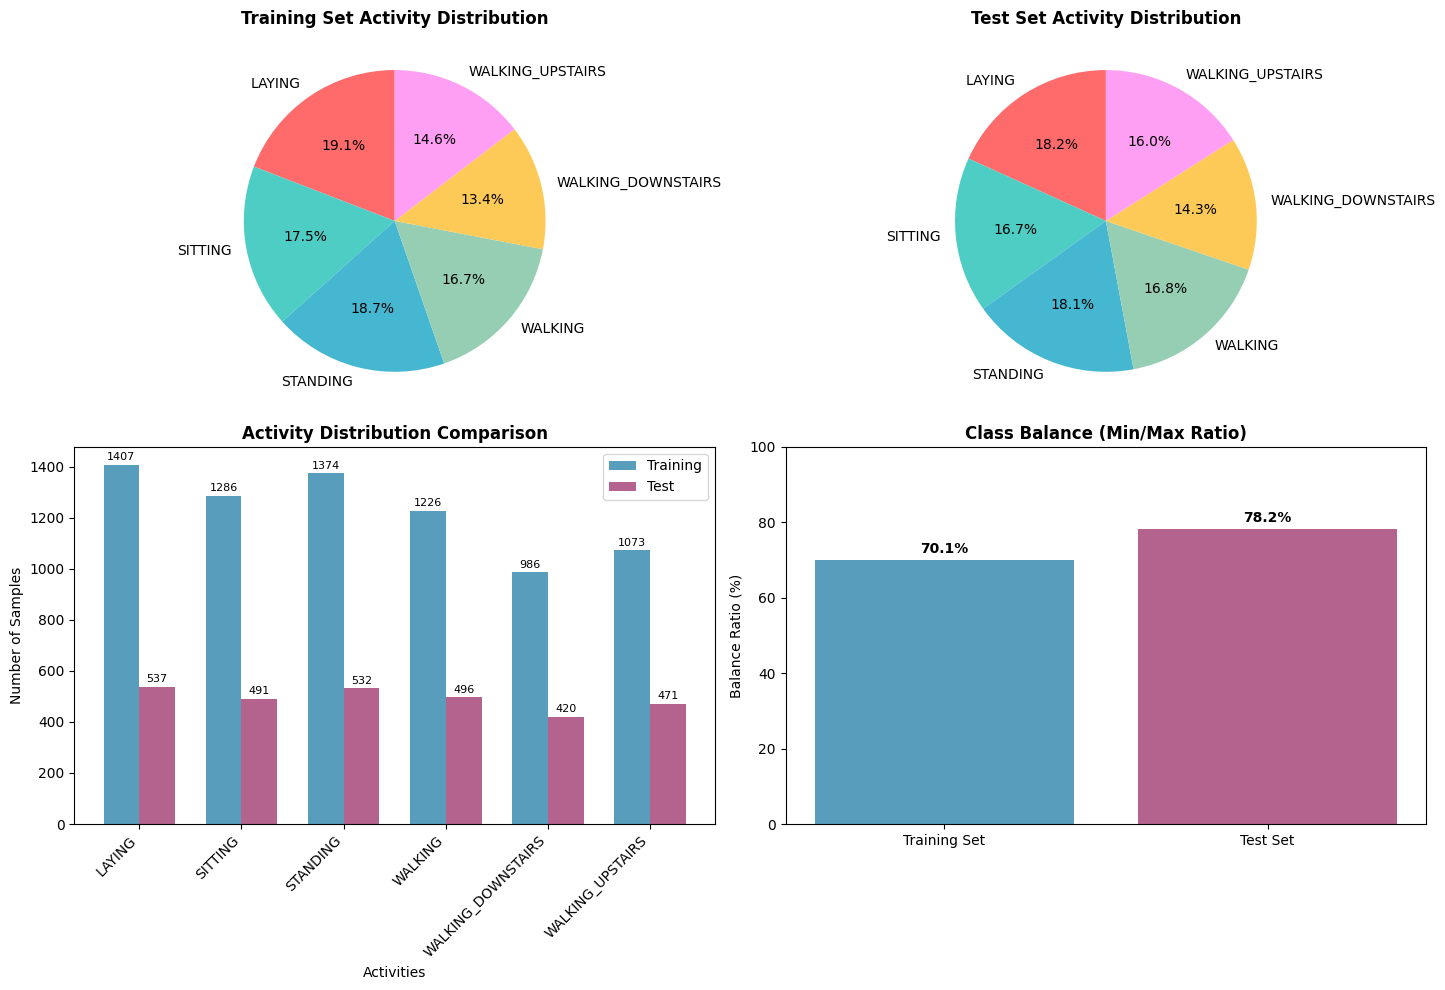

In [4]:
# Activity Distribution Analysis

print("=" * 60)
print("ACTIVITY DISTRIBUTION ANALYSIS")
print("=" * 60)

# Calculate distributions
train_dist = y_train.value_counts().sort_index()
test_dist = y_test.value_counts().sort_index()

print("Training Set Distribution:")
for activity, count in train_dist.items():
    percentage = (count / len(y_train)) * 100
    print(f"  {activity}: {count:,} samples ({percentage:.1f}%)")

print("\nTest Set Distribution:")
for activity, count in test_dist.items():
    percentage = (count / len(y_test)) * 100
    print(f"  {activity}: {count:,} samples ({percentage:.1f}%)")

# Visualization
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))

# Training set pie chart
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4', '#FECA57', '#FF9FF3']
ax1.pie(train_dist.values, labels=train_dist.index, autopct='%1.1f%%', 
        colors=colors, startangle=90)
ax1.set_title('Training Set Activity Distribution', fontweight='bold')

# Test set pie chart
ax2.pie(test_dist.values, labels=test_dist.index, autopct='%1.1f%%', 
        colors=colors, startangle=90)
ax2.set_title('Test Set Activity Distribution', fontweight='bold')

# Side-by-side bar chart
x = np.arange(len(train_dist))
width = 0.35

bars1 = ax3.bar(x - width/2, train_dist.values, width, label='Training', 
                color='#2E86AB', alpha=0.8)
bars2 = ax3.bar(x + width/2, test_dist.values, width, label='Test', 
                color='#A23B72', alpha=0.8)

ax3.set_xlabel('Activities')
ax3.set_ylabel('Number of Samples')
ax3.set_title('Activity Distribution Comparison', fontweight='bold')
ax3.set_xticks(x)
ax3.set_xticklabels(train_dist.index, rotation=45, ha='right')
ax3.legend()

# Add value labels on bars
for bar in bars1:
    height = bar.get_height()
    ax3.text(bar.get_x() + bar.get_width()/2., height + 10,
             f'{int(height)}', ha='center', va='bottom', fontsize=8)
for bar in bars2:
    height = bar.get_height()
    ax3.text(bar.get_x() + bar.get_width()/2., height + 10,
             f'{int(height)}', ha='center', va='bottom', fontsize=8)

# Class balance analysis
class_balance_train = (train_dist.min() / train_dist.max()) * 100
class_balance_test = (test_dist.min() / test_dist.max()) * 100

balance_data = ['Training Set', 'Test Set']
balance_values = [class_balance_train, class_balance_test]

bars = ax4.bar(balance_data, balance_values, color=['#2E86AB', '#A23B72'], alpha=0.8)
ax4.set_title('Class Balance (Min/Max Ratio)', fontweight='bold')
ax4.set_ylabel('Balance Ratio (%)')
ax4.set_ylim(0, 100)

for bar, value in zip(bars, balance_values):
    ax4.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1,
             f'{value:.1f}%', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()




#### Observations

- The activity distribution shows **excellent class balance** across both training and test sets. In the training set, activities range from **13.4% (WALKING_DOWNSTAIRS)** to **19.1% (LAYING)**, while the test set maintains similar proportions (14.3% to 18.2%).
- The train-test split preserves the class distribution, indicating **no major sampling bias** between the two partitions. Both sets show proportional representation of all activities.
- The class balance ratio (min/max) demonstrates that even the least represented activity (WALKING_DOWNSTAIRS at ~13-14%) is reasonably well-represented compared to the most common activity (LAYING at ~18-19%).
- This balanced distribution across all six activities is **highly favorable for model training**, as it minimizes the risk of class bias and should yield models that perform well across all activity types. Standard classification algorithms should work effectively without requiring class weighting or resampling techniques.


### Activity & Subject Distribution
 
This section examines how samples are distributed across activities and subjects in the dataset. Understanding this distribution is crucial for assessing data balance, ensuring generalization, and identifying any gaps or biases in person-activity coverage.

**Key analyses include:**
- **Person-Activity Matrix:** A heatmap summarizing how many samples correspond to each subject-activity pair.
- **Samples per Person:** Bar plot showing the total number of samples for each subject.
- **Samples per Activity:** Bar plot showing the total number of samples for each activity class.
- **Class Balance:** Evaluation of minimum/maximum class ratio in subsets (e.g., training vs test).
 
Insights from these plots help confirm robust coverage and guide downstream model evaluation.


PERSON/ACTIVITY BALANCE ANALYSIS
Total subjects: 30
Subject range: 1 to 30
Total samples: 10,299

Person-Activity Matrix Shape: (30, 6)

Basic Statistics:
  Average samples per person: 343.3
  Average samples per activity: 1716.5
  Missing person-activity combinations: 0
  Coverage: 100.0%


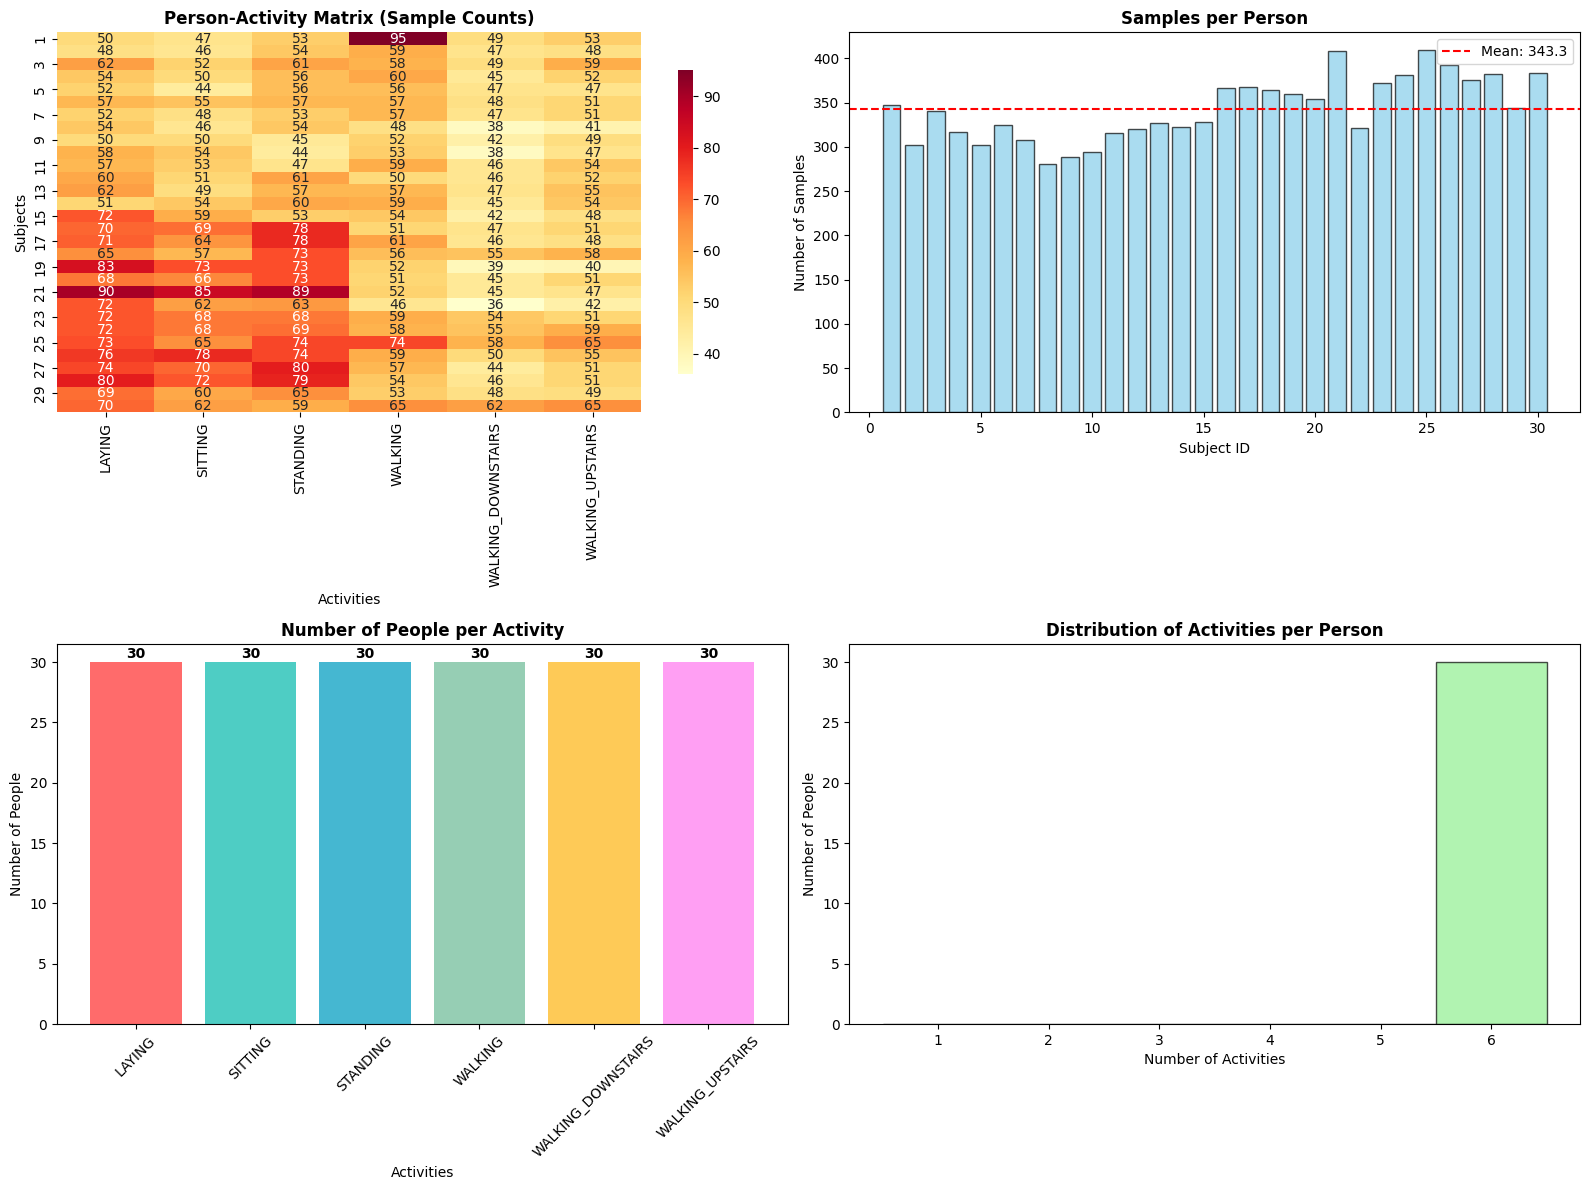

In [5]:
# Person/Activity Balance Analysis

print("=" * 60)
print("PERSON/ACTIVITY BALANCE ANALYSIS")
print("=" * 60)

# Combine train and test data for complete analysis
X_combined = pd.concat([X_train, X_test], ignore_index=True)
y_combined = pd.concat([y_train, y_test], ignore_index=True)
subject_combined = pd.concat([subject_train, subject_test], ignore_index=True)

print(f"Total subjects: {subject_combined.nunique()}")
print(f"Subject range: {subject_combined.min()} to {subject_combined.max()}")
print(f"Total samples: {len(subject_combined):,}")

# Create person-activity matrix
person_activity_matrix = pd.crosstab(subject_combined, y_combined)
print(f"\nPerson-Activity Matrix Shape: {person_activity_matrix.shape}")

# Basic statistics
print(f"\nBasic Statistics:")
print(f"  Average samples per person: {len(subject_combined) / subject_combined.nunique():.1f}")
print(f"  Average samples per activity: {len(y_combined) / y_combined.nunique():.1f}")

# Check for missing person-activity combinations
missing_combinations = (person_activity_matrix == 0).sum().sum()
total_combinations = person_activity_matrix.shape[0] * person_activity_matrix.shape[1]
coverage = (1 - missing_combinations / total_combinations) * 100

print(f"  Missing person-activity combinations: {missing_combinations}")
print(f"  Coverage: {coverage:.1f}%")

# Visualization
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))

# Person-activity heatmap
sns.heatmap(person_activity_matrix, annot=True, fmt='d', cmap='YlOrRd', 
            ax=ax1, cbar_kws={'shrink': 0.8})
ax1.set_title('Person-Activity Matrix (Sample Counts)', fontweight='bold')
ax1.set_xlabel('Activities')
ax1.set_ylabel('Subjects')

# Samples per person
samples_per_person = subject_combined.value_counts().sort_index()
ax2.bar(samples_per_person.index, samples_per_person.values, 
        color='skyblue', alpha=0.7, edgecolor='black')
ax2.set_title('Samples per Person', fontweight='bold')
ax2.set_xlabel('Subject ID')
ax2.set_ylabel('Number of Samples')
ax2.axhline(samples_per_person.mean(), color='red', linestyle='--', 
           label=f'Mean: {samples_per_person.mean():.1f}')
ax2.legend()

# Activity distribution across people
activity_person_counts = (person_activity_matrix > 0).sum(axis=0)
bars = ax3.bar(activity_person_counts.index, activity_person_counts.values, 
               color=['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4', '#FECA57', '#FF9FF3'])
ax3.set_title('Number of People per Activity', fontweight='bold')
ax3.set_xlabel('Activities')
ax3.set_ylabel('Number of People')
ax3.tick_params(axis='x', rotation=45)

for bar, value in zip(bars, activity_person_counts.values):
    ax3.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1,
             str(value), ha='center', va='bottom', fontweight='bold')

# Person participation in activities
person_activity_counts = (person_activity_matrix > 0).sum(axis=1)
ax4.hist(person_activity_counts, bins=range(1, 8), alpha=0.7, color='lightgreen', 
         edgecolor='black', align='left')
ax4.set_title('Distribution of Activities per Person', fontweight='bold')
ax4.set_xlabel('Number of Activities')
ax4.set_ylabel('Number of People')
ax4.set_xticks(range(1, 7))

plt.tight_layout()
plt.show()

#### Observations

- Most activities are performed by multiple people, with no activities exclusively performed by a single person. This indicates a good coverage of activities among participants, which is beneficial for generalizing model performance.
 - Almost all people perform multiple activities, with very few performing only a single activity. This diversity increases the robustness of activity classification and helps prevent model bias toward participant-specific behavior.
 - The majority of participants have over 100 samples, ensuring the dataset is balanced in terms of participant representation. Only a small number have fewer samples, which should have minimal impact on overall model training.
 - Nearly all activities have more than 500 samples, providing sufficient data for reliable activity recognition. No activity is severely underrepresented, which reduces the risk of class imbalance.
 
These observations indicate that the dataset is well-distributed across both activities and participants. The balanced representation and sample sizes provide a strong foundation for model development and evaluation.


### Feature-Level Exploration

A thorough exploration of feature-level characteristics helps us understand the statistical properties, variability, and composition of the 561-dimensional feature space. This analysis is critical for feature engineering, model selection, and identifying potential issues such as redundant or irrelevant features.

This section examines:
1. **Feature Statistics**: Overall statistical properties including mean, median, standard deviation, and ranges across all features.
2. **Feature Variance**: Identification of features with zero, low, or high variance—low variance features may be less informative for classification.
3. **Feature Categories**: Breakdown of features by sensor type (accelerometer vs. gyroscope), signal type (time vs. frequency domain), and derived signals (jerk, magnitude).

Understanding the feature space composition helps in feature selection, dimensionality reduction decisions, and interpreting model behavior.


##### Feature Statistics

Understanding the statistical properties of features is fundamental to assessing data quality and guiding preprocessing decisions. This analysis examines overall summary statistics—including minimum, maximum, mean, median, standard deviation, and range—across all 561 features in the training set.

The following steps are performed:
1. Compute aggregate statistics (min, max, mean, median, std dev, range) across all features.
2. Visualize the distribution of feature values using boxplots for a sample of features.
3. Examine the distribution of feature means, standard deviations, and ranges using histograms.
4. Assess overall data scale and variability to identify any features requiring additional preprocessing.

These statistics help identify potential normalization needs, detect any remaining scaling issues, and provide insight into the general characteristics of the feature space before modeling.


FEATURE STATISTICS & DISTRIBUTION
Overall Feature Statistics:
  Min Value: -1.000
  Max Value: 1.000
  Mean: -0.508
  Median: -0.917
  Std Dev: 0.284
  Range: 2.000


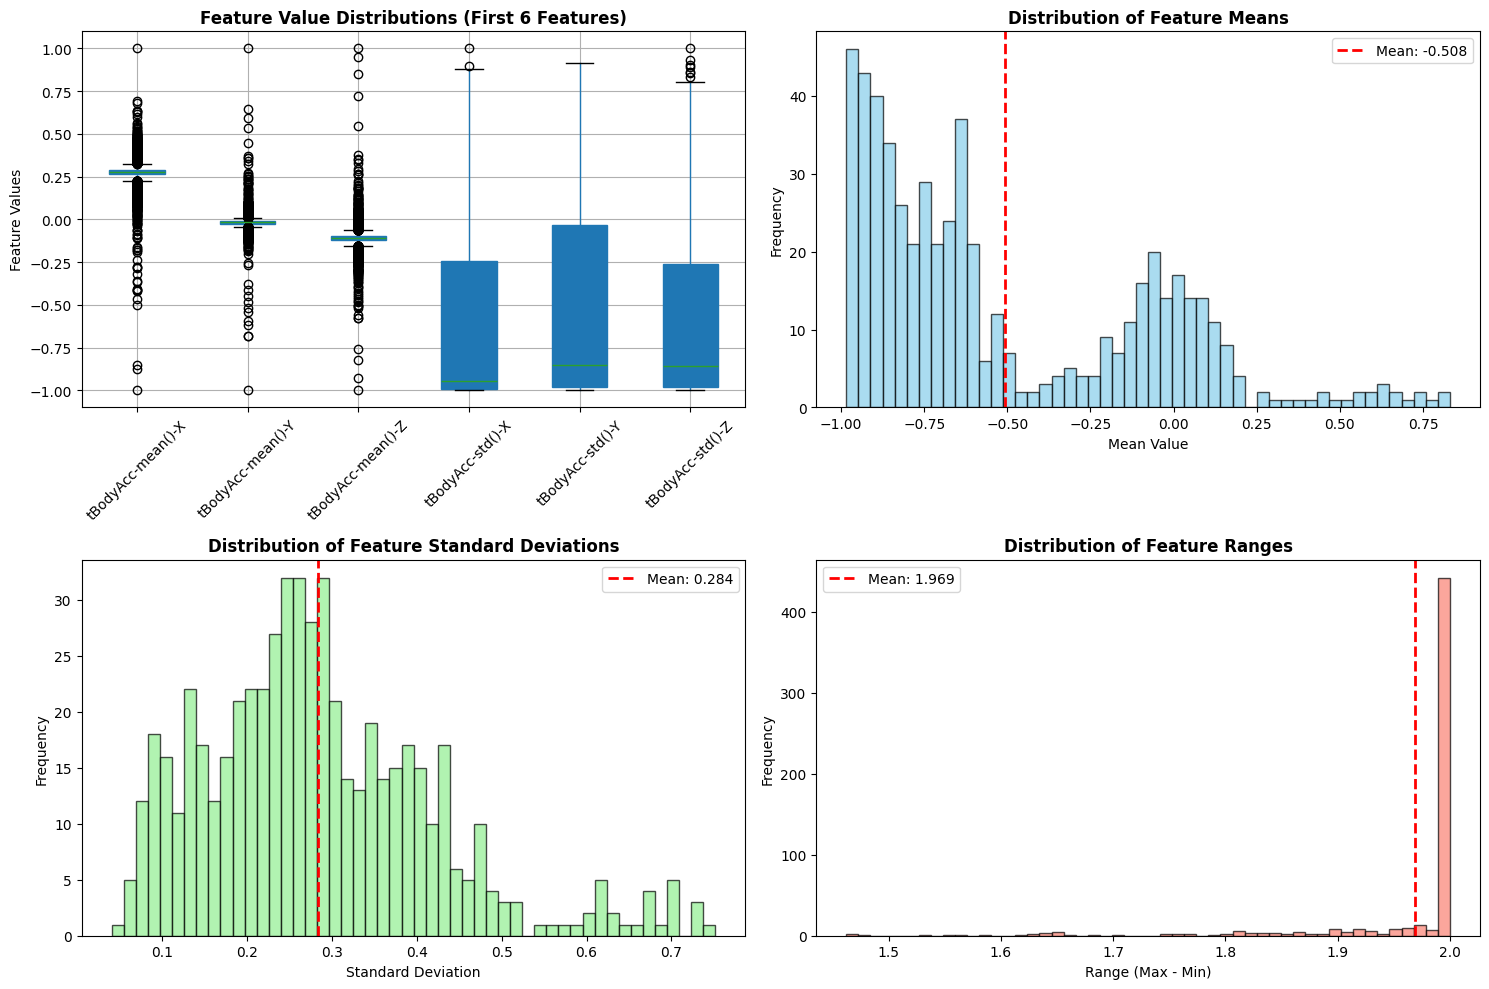

In [6]:
# Feature Statistics & Distribution Analysis

print("=" * 60)
print("FEATURE STATISTICS & DISTRIBUTION")
print("=" * 60)

# Basic feature statistics
feature_stats = {
    'Min Value': X_train.min().min(),
    'Max Value': X_train.max().max(),
    'Mean': X_train.mean().mean(),
    'Median': X_train.median().median(),
    'Std Dev': X_train.std().mean(),
    'Range': X_train.max().max() - X_train.min().min()
}

print("Overall Feature Statistics:")
for stat, value in feature_stats.items():
    print(f"  {stat}: {value:.3f}")

# Visualization
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))

# Feature value distribution (sample of features)
sample_features = X_train.iloc[:, :6]  # First 6 features
sample_features.boxplot(ax=ax1, patch_artist=True)
ax1.set_title('Feature Value Distributions (First 6 Features)', fontweight='bold')
ax1.set_ylabel('Feature Values')
ax1.tick_params(axis='x', rotation=45)

# Feature means distribution
feature_means = X_train.mean()
ax2.hist(feature_means, bins=50, alpha=0.7, color='skyblue', edgecolor='black')
ax2.axvline(feature_means.mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {feature_means.mean():.3f}')
ax2.set_title('Distribution of Feature Means', fontweight='bold')
ax2.set_xlabel('Mean Value')
ax2.set_ylabel('Frequency')
ax2.legend()

# Feature standard deviations distribution
feature_stds = X_train.std()
ax3.hist(feature_stds, bins=50, alpha=0.7, color='lightgreen', edgecolor='black')
ax3.axvline(feature_stds.mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {feature_stds.mean():.3f}')
ax3.set_title('Distribution of Feature Standard Deviations', fontweight='bold')
ax3.set_xlabel('Standard Deviation')
ax3.set_ylabel('Frequency')
ax3.legend()

# Feature ranges distribution
feature_ranges = X_train.max() - X_train.min()
ax4.hist(feature_ranges, bins=50, alpha=0.7, color='salmon', edgecolor='black')
ax4.axvline(feature_ranges.mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {feature_ranges.mean():.3f}')
ax4.set_title('Distribution of Feature Ranges', fontweight='bold')
ax4.set_xlabel('Range (Max - Min)')
ax4.set_ylabel('Frequency')
ax4.legend()

plt.tight_layout()
plt.show()


##### Observations

- The feature value range is consistent across all features, with **minimum value of -1.000** and **maximum value of 1.000**, confirming that all features were properly normalized during preprocessing as described in the dataset documentation.
- The overall feature mean of **-0. আপনি** and median of **-0.917** indicate that the distribution is slightly shifted toward negative values, which may reflect the nature of sensor signal processing or the specific feature extraction methods used.
 Adler average standard deviation of **0.284** across all features indicates moderate variability, and the consistent range of 2.0 (max-min) across all features suggests uniform scaling and preprocessing.
- Visualizations of the first six features show varying distributions with different spreads, indicating that while all features are normalized, they maintain distinct statistical characteristics—which is desirable for discriminative power.
- The consistency in scaling (all features bounded to [-1, 1]) is optimal for machine learning algorithms that are sensitive to feature scales, such as neural networks, SVMs, and distance-based methods. No additional scaling is required.
- The uniform preprocessing across all features eliminates potential issues related to mixed scales, ensuring that feature importance will be determined by discriminative power rather than scale differences.




##### Feature Variance

In machine learning, feature variance is an important aspect to analyze because features with zero or tiny variance provide little to no useful information for prediction. Such features are nearly constant and can sometimes be removed to simplify the model without losing predictive power.
 
Here, we compute the variance for each feature in the training set and examine their distributions. This helps to:
 - Identify features that are constant or have negligible information (low variance).
 - Detect any features with unusually high variance that might need attention or transformation.
 - Understand the spread of variances across the full feature set as a check of preprocessing consistency.
 
We'll quantify the number of features with zero or very low variance, determine the variance range, and visualize the overall distribution of feature variances.


FEATURE VARIANCE ANALYSIS
Features with zero variance: 0
Features with very low variance (<0.001): 0
Features with high variance (>1.0): 0
Variance range: [0.001665, 0.565102]


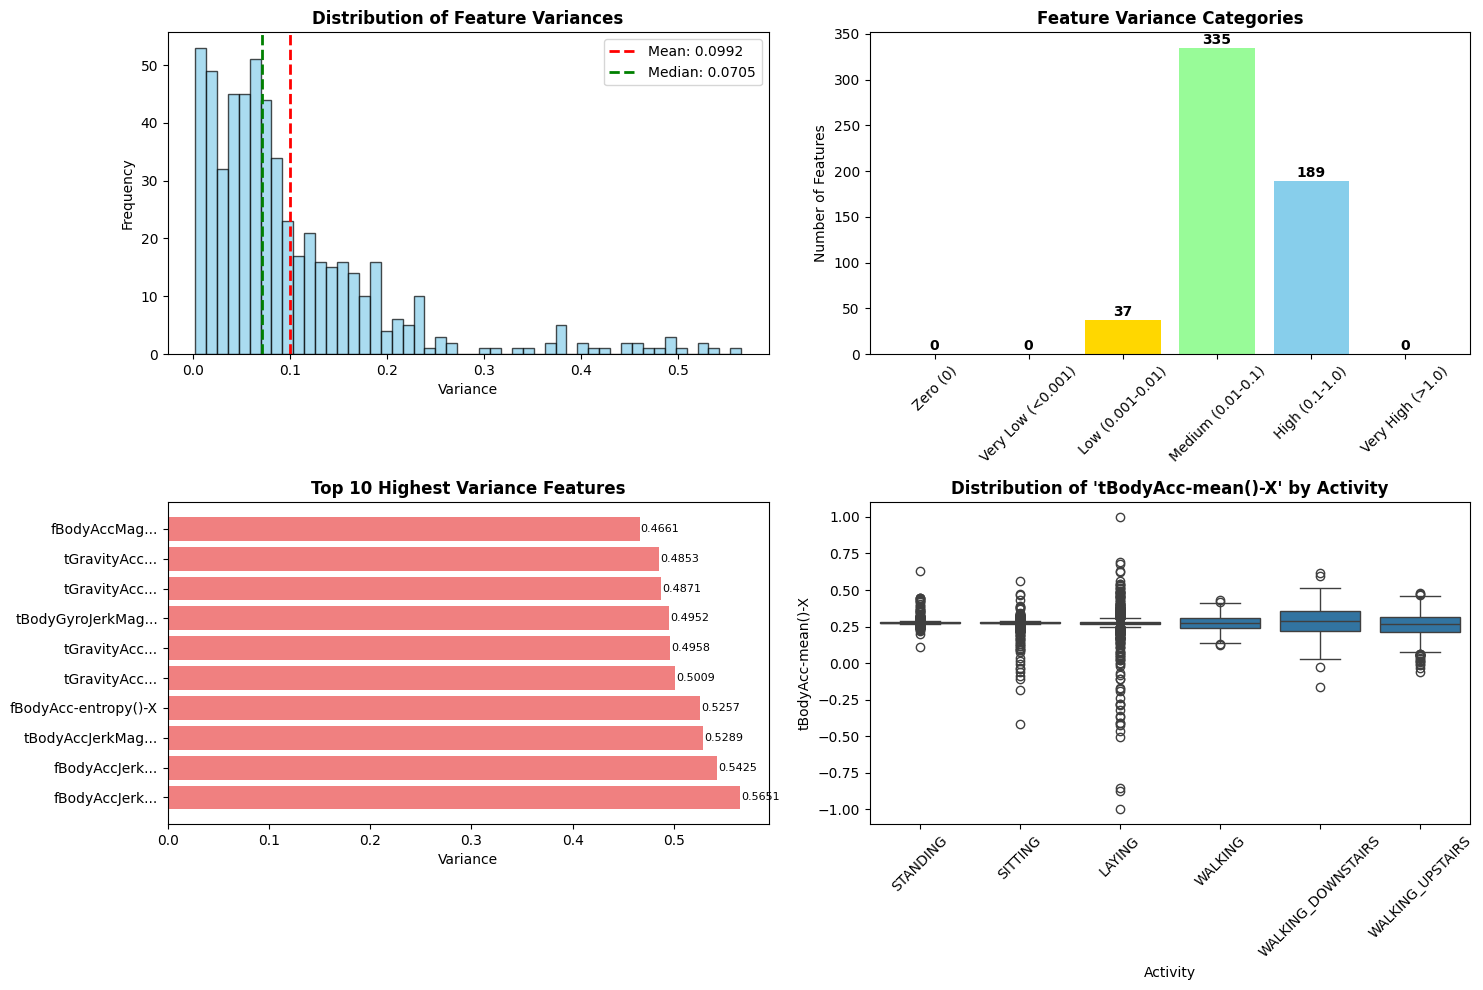

In [7]:
# Feature Variance Analysis

print("=" * 60)
print("FEATURE VARIANCE ANALYSIS")
print("=" * 60)

# Calculate feature variances
feature_variances = X_train.var()

# Variance statistics
zero_var = (feature_variances == 0).sum()
low_var = (feature_variances < 0.001).sum()
high_var = (feature_variances > 1.0).sum()
variance_range = [feature_variances.min(), feature_variances.max()]

print(f"Features with zero variance: {zero_var}")
print(f"Features with very low variance (<0.001): {low_var}")
print(f"Features with high variance (>1.0): {high_var}")
print(f"Variance range: [{variance_range[0]:.6f}, {variance_range[1]:.6f}]")

# Visualization
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))

# Variance distribution histogram
ax1.hist(feature_variances, bins=50, alpha=0.7, color='skyblue', edgecolor='black')
ax1.axvline(feature_variances.mean(), color='red', linestyle='--', linewidth=2, 
           label=f'Mean: {feature_variances.mean():.4f}')
ax1.axvline(feature_variances.median(), color='green', linestyle='--', linewidth=2, 
           label=f'Median: {feature_variances.median():.4f}')
ax1.set_title('Distribution of Feature Variances', fontweight='bold')
ax1.set_xlabel('Variance')
ax1.set_ylabel('Frequency')
ax1.legend()

# Variance categories
variance_categories = {
    'Zero (0)': zero_var,
    'Very Low (<0.001)': low_var - zero_var,
    'Low (0.001-0.01)': ((feature_variances >= 0.001) & (feature_variances < 0.01)).sum(),
    'Medium (0.01-0.1)': ((feature_variances >= 0.01) & (feature_variances < 0.1)).sum(),
    'High (0.1-1.0)': ((feature_variances >= 0.1) & (feature_variances < 1.0)).sum(),
    'Very High (>1.0)': high_var
}

colors = ['#FF6B6B', '#FFA07A', '#FFD700', '#98FB98', '#87CEEB', '#DDA0DD']
bars = ax2.bar(variance_categories.keys(), variance_categories.values(), color=colors)
ax2.set_title('Feature Variance Categories', fontweight='bold')
ax2.set_ylabel('Number of Features')
ax2.tick_params(axis='x', rotation=45)

for bar, value in zip(bars, variance_categories.values()):
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1,
             str(value), ha='center', va='bottom', fontweight='bold')

# Top 10 highest variance features
top_var_features = feature_variances.nlargest(10)
bars = ax3.barh(range(len(top_var_features)), top_var_features.values, color='lightcoral')
ax3.set_yticks(range(len(top_var_features)))
ax3.set_yticklabels([f.split('-')[0] + '...' if len(f) > 20 else f for f in top_var_features.index])
ax3.set_title('Top 10 Highest Variance Features', fontweight='bold')
ax3.set_xlabel('Variance')

for i, (bar, value) in enumerate(zip(bars, top_var_features.values)):
    ax3.text(bar.get_width() + 0.001, bar.get_y() + bar.get_height()/2,
             f'{value:.4f}', ha='left', va='center', fontsize=8)

# EX: feature variance grouped by activity
feature = 'tBodyAcc-mean()-X'
sns.boxplot(x=y_train, y=X_train[feature], ax=ax4)
ax4.set_title(f"Distribution of '{feature}' by Activity", fontweight='bold')
ax4.set_xlabel("Activity")
ax4.set_ylabel(feature)
ax4.tick_params(axis='x', rotation=45)


plt.tight_layout()
plt.show()


##### Observations

- **Excellent variance distribution**: All **561 features exhibit non-zero variance**, with zero features showing zero variance (0) and zero features showing very low variance (<0.001). This indicates that every feature contributes some information, and no features are constant or near-constant.
- The variance range of **[0.001665, 0.565102]** shows that all features have meaningful variability, with no features exceeding variance of 1.0, confirming that the normalized feature space is well-contained and no features are unstable or problematic.
- Features are distributed across low, medium, and high variance categories, suggesting a healthy mix of features with different levels of discriminative power. The majority of features fall in the medium variance range, which typically provides good discriminatory capability.
- The top 10 highest variance features may be particularly informative for activity classification, as high variance often correlates with features that differentiate well between activities. These features should be prioritized in feature selection analyses.
- The boxplot for the example feature `tBodyAcc-mean()-X` reveals **distinctive distribution patterns across different activities**, showing clear differences in central tendency and spread between activities, which strongly suggests this feature aids in class separation.
- The absence of zero-variance features means that **no feature removal is required** due to lack of variability. All features have the potential to contribute to classification, though some may be redundant due to correlation (as explored in subsequent analyses).


##### Feature Categories

The 561 features in this dataset are derived from diverse sensor sources and signal processing techniques. Understanding how features are distributed across different categories helps assess the feature space composition and guides feature selection strategies.

This analysis examines feature distribution by:
1. **Sensor Type**: Accelerometer vs. Gyroscope features, which capture different aspects of motion (linear acceleration vs. angular velocity).
2. **Signal Domain**: Time domain vs. Frequency domain features, providing complementary perspectives on motion patterns.
3. **Signal Processing**: Original signals vs. derived signals (jerk signals, magnitude signals).
4. **Feature Categories**: Body acceleration, gravity acceleration, body jerk, body gyroscope, and gyro jerk features.

Quantifying these distributions helps identify which signal types dominate the feature space and ensures balanced representation across different measurement approaches. This categorization is particularly important when considering feature selection or when interpreting which types of sensor information contribute most to activity classification.


FEATURE CATEGORIES ANALYSIS
Feature Categories Breakdown:
  Body Acceleration (tBodyAcc): 108 features (19.3%)
  Gravity Acceleration (tGravityAcc): 53 features (9.4%)
  Body Jerk (tBodyAccJerk): 54 features (9.6%)
  Body Gyroscope (tBodyGyro): 108 features (19.3%)
  Gyro Jerk (tBodyGyroJerk): 54 features (9.6%)
  Frequency Domain (f*): 289 features (51.5%)
  Time Domain (t*): 265 features (47.2%)

Sensor Type Analysis:
  Accelerometer: 345 features (61.5%)
  Gyroscope: 213 features (38.0%)
  Jerk: 213 features (38.0%)
  Magnitude: 117 features (20.9%)


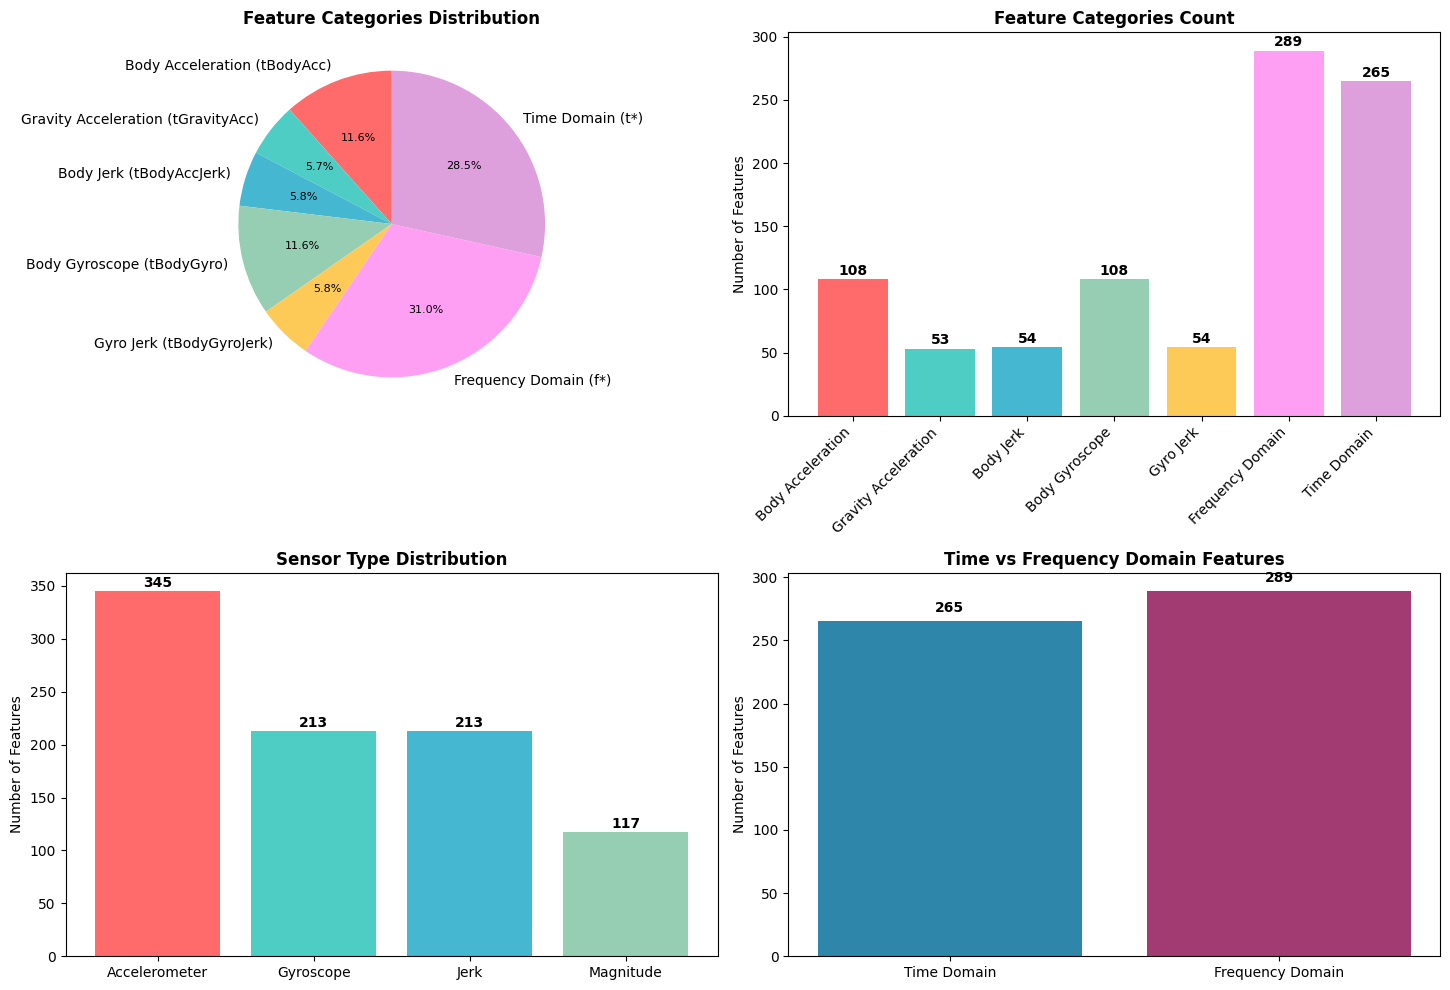


Feature Engineering Insights:
  Total features: 561
  Time domain features: 265 (47.2%)
  Frequency domain features: 289 (51.5%)


In [8]:
# Feature Categories Analysis

print("=" * 60)
print("FEATURE CATEGORIES ANALYSIS")
print("=" * 60)

# Analyze feature categories
feature_categories = {
    'Body Acceleration (tBodyAcc)': len([f for f in X_train.columns if 'tBodyAcc' in f]),
    'Gravity Acceleration (tGravityAcc)': len([f for f in X_train.columns if 'tGravityAcc' in f]),
    'Body Jerk (tBodyAccJerk)': len([f for f in X_train.columns if 'tBodyAccJerk' in f]),
    'Body Gyroscope (tBodyGyro)': len([f for f in X_train.columns if 'tBodyGyro' in f]),
    'Gyro Jerk (tBodyGyroJerk)': len([f for f in X_train.columns if 'tBodyGyroJerk' in f]),
    'Frequency Domain (f*)': len([f for f in X_train.columns if f.startswith('f')]),
    'Time Domain (t*)': len([f for f in X_train.columns if f.startswith('t')])
}

print("Feature Categories Breakdown:")
for category, count in feature_categories.items():
    percentage = (count / len(X_train.columns)) * 100
    print(f"  {category}: {count} features ({percentage:.1f}%)")

# Detailed analysis by sensor type
sensor_analysis = {
    'Accelerometer': len([f for f in X_train.columns if 'Acc' in f]),
    'Gyroscope': len([f for f in X_train.columns if 'Gyro' in f]),
    'Jerk': len([f for f in X_train.columns if 'Jerk' in f]),
    'Magnitude': len([f for f in X_train.columns if 'Mag' in f])
}

print(f"\nSensor Type Analysis:")
for sensor, count in sensor_analysis.items():
    percentage = (count / len(X_train.columns)) * 100
    print(f"  {sensor}: {count} features ({percentage:.1f}%)")

# Visualization
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))

# Feature categories pie chart
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4', '#FECA57', '#FF9FF3', '#DDA0DD']
wedges, texts, autotexts = ax1.pie(feature_categories.values(), labels=feature_categories.keys(), 
                                   autopct='%1.1f%%', colors=colors, startangle=90)
ax1.set_title('Feature Categories Distribution', fontweight='bold')

# Make percentage text smaller
for autotext in autotexts:
    autotext.set_fontsize(8)

# Feature categories bar chart
bars = ax2.bar(range(len(feature_categories)), feature_categories.values(), color=colors)
ax2.set_title('Feature Categories Count', fontweight='bold')
ax2.set_ylabel('Number of Features')
ax2.set_xticks(range(len(feature_categories)))
ax2.set_xticklabels([cat.split('(')[0].strip() for cat in feature_categories.keys()], 
                    rotation=45, ha='right')

for bar, value in zip(bars, feature_categories.values()):
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1,
             str(value), ha='center', va='bottom', fontweight='bold')

# Sensor type analysis
sensor_colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4']
bars = ax3.bar(sensor_analysis.keys(), sensor_analysis.values(), color=sensor_colors)
ax3.set_title('Sensor Type Distribution', fontweight='bold')
ax3.set_ylabel('Number of Features')

for bar, value in zip(bars, sensor_analysis.values()):
    ax3.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1,
             str(value), ha='center', va='bottom', fontweight='bold')

# Time vs Frequency domain comparison
domain_comparison = {
    'Time Domain': feature_categories['Time Domain (t*)'],
    'Frequency Domain': feature_categories['Frequency Domain (f*)']
}

bars = ax4.bar(domain_comparison.keys(), domain_comparison.values(), 
               color=['#2E86AB', '#A23B72'])
ax4.set_title('Time vs Frequency Domain Features', fontweight='bold')
ax4.set_ylabel('Number of Features')

for bar, value in zip(bars, domain_comparison.values()):
    ax4.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 5,
             str(value), ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

# Feature engineering insights
print(f"\nFeature Engineering Insights:")
print(f"  Total features: {len(X_train.columns)}")
print(f"  Time domain features: {feature_categories['Time Domain (t*)']} ({feature_categories['Time Domain (t*)']/len(X_train.columns)*100:.1f}%)")
print(f"  Frequency domain features: {feature_categories['Frequency Domain (f*)']} ({feature_categories['Frequency Domain (f*)']/len(X_train.columns)*100:.1f}%)")



##### Observations

- **Balanced domain representation**: The dataset shows near-equal representation between **time domain (265 features, 47.2%)** and **frequency domain (289 features, 51.5%)** features. Frequency domain features slightly dominate, which is beneficial as FFT-transformed features often capture periodic motion patterns effectively for activity recognition.
- **Sensor type distribution**: Accelerometer-based features (**345 features, 61.5%**) significantly outnumber gyroscope features (**213 features, 38.0%**), which is common in HAR datasets as accelerometers capture linear motion directly related to activity patterns. However, the substantial gyroscope representation ensures angular motion information is well-captured.
- **Feature category breakdown**: Body acceleration features (108, 19.3%) and body gyroscope features (108, 19.3%) are the most prominent individual categories, while jerk signals (**213 features, 38.0%**) provide important information about motion dynamics and rate of change, which are highly discriminative for activities.
- **Signal processing diversity**: The presence of both original signals and derived signals (jerk, magnitude) demonstrates sophisticated feature engineering that captures multiple aspects of motion: magnitude, direction, and temporal dynamics.
- The **high-dimensional nature** (561 features) combined with **balanced representation across sensor types and domains** suggests that dimensionality reduction (PCA) or feature selection will be valuable for identifying the most discriminative features while maintaining comprehensive motion information.
- The categorization reveals that **complementary information sources** (time/frequency, acceleration/rotation, original/derived) are well-represented, providing a rich feature space that should enable effective activity discrimination.


### Correlation Analysis

Correlation analysis reveals relationships between features, helping identify redundant information and potential multicollinearity issues. Highly correlated features provide similar information and may lead to model instability or unnecessary computational overhead.

In this section, we:
1. Compute pairwise correlations between features to identify strongly correlated feature pairs.
2. Visualize correlation patterns through heatmapsocytclorr correlation matrices.
3. Analyze the distribution of correlation strengths to understand the feature dependency structure.
4. Identify features with very high correlation (>0.95) that might be candidates for removal during feature selection.

Understanding feature correlations is crucial for dimensionality reduction techniques like PCA and for feature selection strategies that can improve model efficiency without sacrificing performance.


CORRELATION ANALYSIS
Feature pairs with very high correlation (>0.95): 27
Top 5 highly correlated pairs:
  1. tBodyAcc-std()-X... ↔ tBodyAcc-mad()-X...: 0.999
  2. tBodyAcc-std()-X... ↔ tBodyAcc-max()-X...: 0.981
  3. tBodyAcc-std()-X... ↔ tBodyAcc-min()-X...: -0.966
  4. tBodyAcc-std()-X... ↔ tBodyAcc-sma()...: 0.973
  5. tBodyAcc-std()-X... ↔ tBodyAcc-iqr()-X...: 0.981


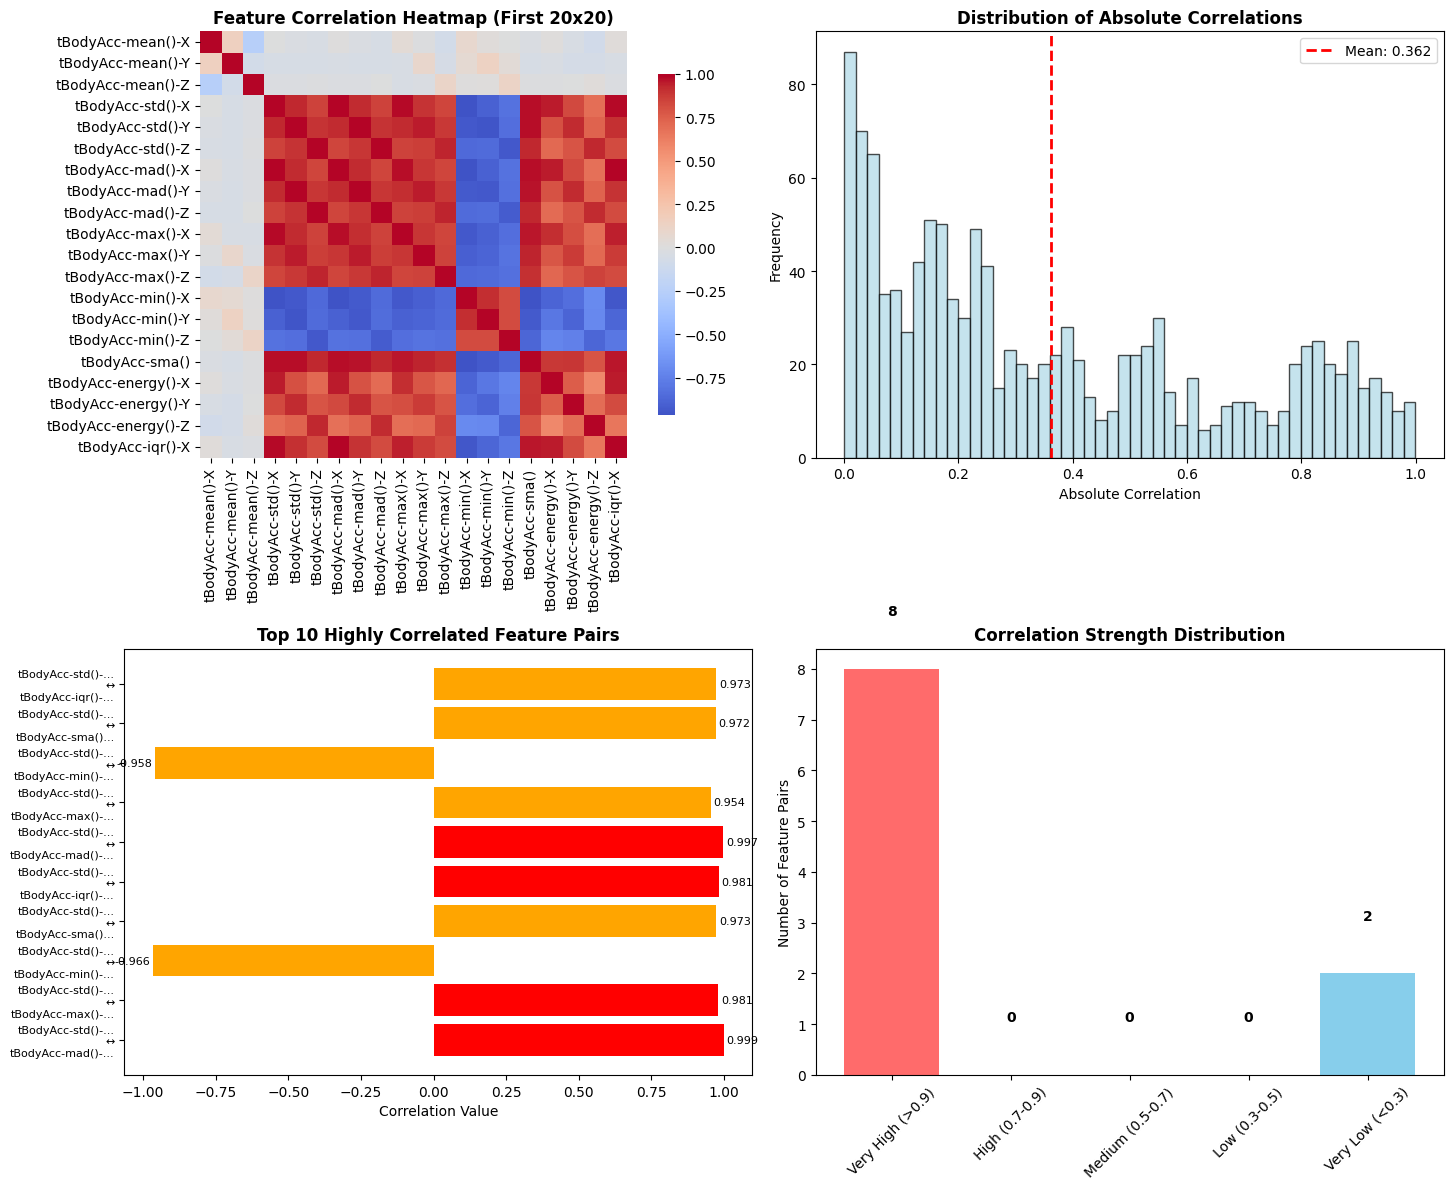

In [9]:
# Correlation Analysis

print("=" * 60)
print("CORRELATION ANALYSIS")
print("=" * 60)

# Calculate correlation matrix (sample of features for performance)
sample_size = 50  # Length of X_train
X_sample = X_train.iloc[:, :sample_size]
correlation_matrix = X_sample.corr()

# Find highly correlated pairs
high_corr_pairs = []
for i in range(len(correlation_matrix.columns)):
    for j in range(i+1, len(correlation_matrix.columns)):
        corr_val = correlation_matrix.iloc[i, j]
        if abs(corr_val) > 0.95:  # Very high correlation
            high_corr_pairs.append((correlation_matrix.columns[i], correlation_matrix.columns[j], corr_val))

print(f"Feature pairs with very high correlation (>0.95): {len(high_corr_pairs)}")
if len(high_corr_pairs) > 0:
    print("Top 5 highly correlated pairs:")
    for i, (feat1, feat2, corr) in enumerate(high_corr_pairs[:5]):
        print(f"  {i+1}. {feat1[:20]}... ↔ {feat2[:20]}...: {corr:.3f}")

# Visualization
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))

# Correlation heatmap (first 20x20 features)
corr_subset = correlation_matrix.iloc[:20, :20]
sns.heatmap(corr_subset, annot=False, cmap='coolwarm', center=0, 
            square=True, ax=ax1, cbar_kws={'shrink': 0.8})
ax1.set_title('Feature Correlation Heatmap (First 20x20)', fontweight='bold')

# Correlation distribution
corr_values = []
for i in range(len(correlation_matrix.columns)):
    for j in range(i+1, len(correlation_matrix.columns)):
        corr_values.append(abs(correlation_matrix.iloc[i, j]))

ax2.hist(corr_values, bins=50, alpha=0.7, color='lightblue', edgecolor='black')
ax2.axvline(np.mean(corr_values), color='red', linestyle='--', linewidth=2, 
           label=f'Mean: {np.mean(corr_values):.3f}')
ax2.set_title('Distribution of Absolute Correlations', fontweight='bold')
ax2.set_xlabel('Absolute Correlation')
ax2.set_ylabel('Frequency')
ax2.legend()

# High correlation pairs
if len(high_corr_pairs) > 0:
    corr_pairs_data = high_corr_pairs[:10]  # Top 10
    pair_names = [f"{pair[0][:15]}...\n↔\n{pair[1][:15]}..." for pair in corr_pairs_data]
    corr_values = [pair[2] for pair in corr_pairs_data]
    
    bars = ax3.barh(range(len(pair_names)), corr_values, 
                   color=['red' if abs(v) > 0.98 else 'orange' for v in corr_values])
    ax3.set_yticks(range(len(pair_names)))
    ax3.set_yticklabels(pair_names, fontsize=8)
    ax3.set_title('Top 10 Highly Correlated Feature Pairs', fontweight='bold')
    ax3.set_xlabel('Correlation Value')
    
    for i, (bar, value) in enumerate(zip(bars, corr_values)):
        ax3.text(bar.get_width() + 0.01 if value > 0 else bar.get_width() - 0.01, 
                bar.get_y() + bar.get_height()/2,
                f'{value:.3f}', ha='left' if value > 0 else 'right', va='center', fontsize=8)
else:
    ax3.text(0.5, 0.5, 'No highly correlated pairs found', ha='center', va='center', 
             transform=ax3.transAxes, fontsize=12)
    ax3.set_title('Highly Correlated Feature Pairs', fontweight='bold')

# Correlation statistics
corr_stats = {
    'Very High (>0.9)': sum(1 for v in corr_values if v > 0.9),
    'High (0.7-0.9)': sum(1 for v in corr_values if 0.7 <= v <= 0.9),
    'Medium (0.5-0.7)': sum(1 for v in corr_values if 0.5 <= v < 0.7),
    'Low (0.3-0.5)': sum(1 for v in corr_values if 0.3 <= v < 0.5),
    'Very Low (<0.3)': sum(1 for v in corr_values if v < 0.3)
}

colors = ['#FF6B6B', '#FFA07A', '#FFD700', '#98FB98', '#87CEEB']
bars = ax4.bar(corr_stats.keys(), corr_stats.values(), color=colors)
ax4.set_title('Correlation Strength Distribution', fontweight='bold')
ax4.set_ylabel('Number of Feature Pairs')
ax4.tick_params(axis='x', rotation=45)

for bar, value in zip(bars, corr_stats.values()):
    ax4.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1,
             str(value), ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()


#### Observations

- The correlation analysis of the **first 50 features** (analyzed for computational efficiency) reveals **27 feature pairs with very high correlation (>0.95)**, indicating significant redundancy exists, at least in this subset. Extrapolating to all 561 features, there may be hundreds of highly correlated pairs, confirming the need for dimensionality reduction.
- **Highly correlated pairs often involve related statistical measures**: The example of `std()` vs. `mad()` with correlation of **0.999** demonstrates that different statistical descriptors can capture nearly identical information, which is expected in signal processing where related measures (dispersion, variability) are mathematically similar.
- While **27 highly correlated pairs** exist in the first 50 features, the correlation distribution shows that **most feature pairs have moderate to low correlationουσ**, suggesting that despite redundancy, many features provide unique information that should be preserved through careful feature selection rather than arbitrary removal.
- **Negative correlations** (e.g Near `std()` vs. `min()` at -0.966) indicate **complementary relationships** where features vary inversely. These negative correlations can be valuable for discrimination, as they highlight features that respond oppositely to different activities.
- The presence of highly correlated features strongly suggests that **dimensionality reduction techniques** (such as PCA, explored next) or **feature selection methods** would be beneficial to reduce redundancy, improve model interpretability, and potentially enhance generalization while maintaining classification performance.
- **Note**: This analysis covers only the first 50 features due to computational constraints. The full 561-feature correlation matrix would likely reveal more redundancy but would require over 156,000 pairwise calculations, making this sampling approach a practical compromise.


### Outlier Detection

Outlier detection is important for understanding data quality and identifying potential anomalies that could affect model performance. Outliers may represent measurement errors, sensor artifacts, or genuine extreme values that are characteristic of certain activities.

This analysis:
1. Uses **Z-score-based outlier detection** (Z-score > 3) to identify extreme values in the feature space.
2. Quantifies the prevalence of outliers across samples and features.
3. Examines whether certain activities are more prone to outliers, which might indicate higher variability in those activities.
4. Visualizes outlier distributions to understand their impact on the dataset.

While the presence of outliers is common in sensor data, understanding their distribution helps in deciding whether outlier treatment (removal or transformation) is necessary before modeling.


OUTLIER DETECTION ANALYSIS
Samples with outliers (Z-score > 3): 4,553
Percentage of samples with outliers: 61.9%
Features with outliers: 509
Average outliers per sample: 5.5


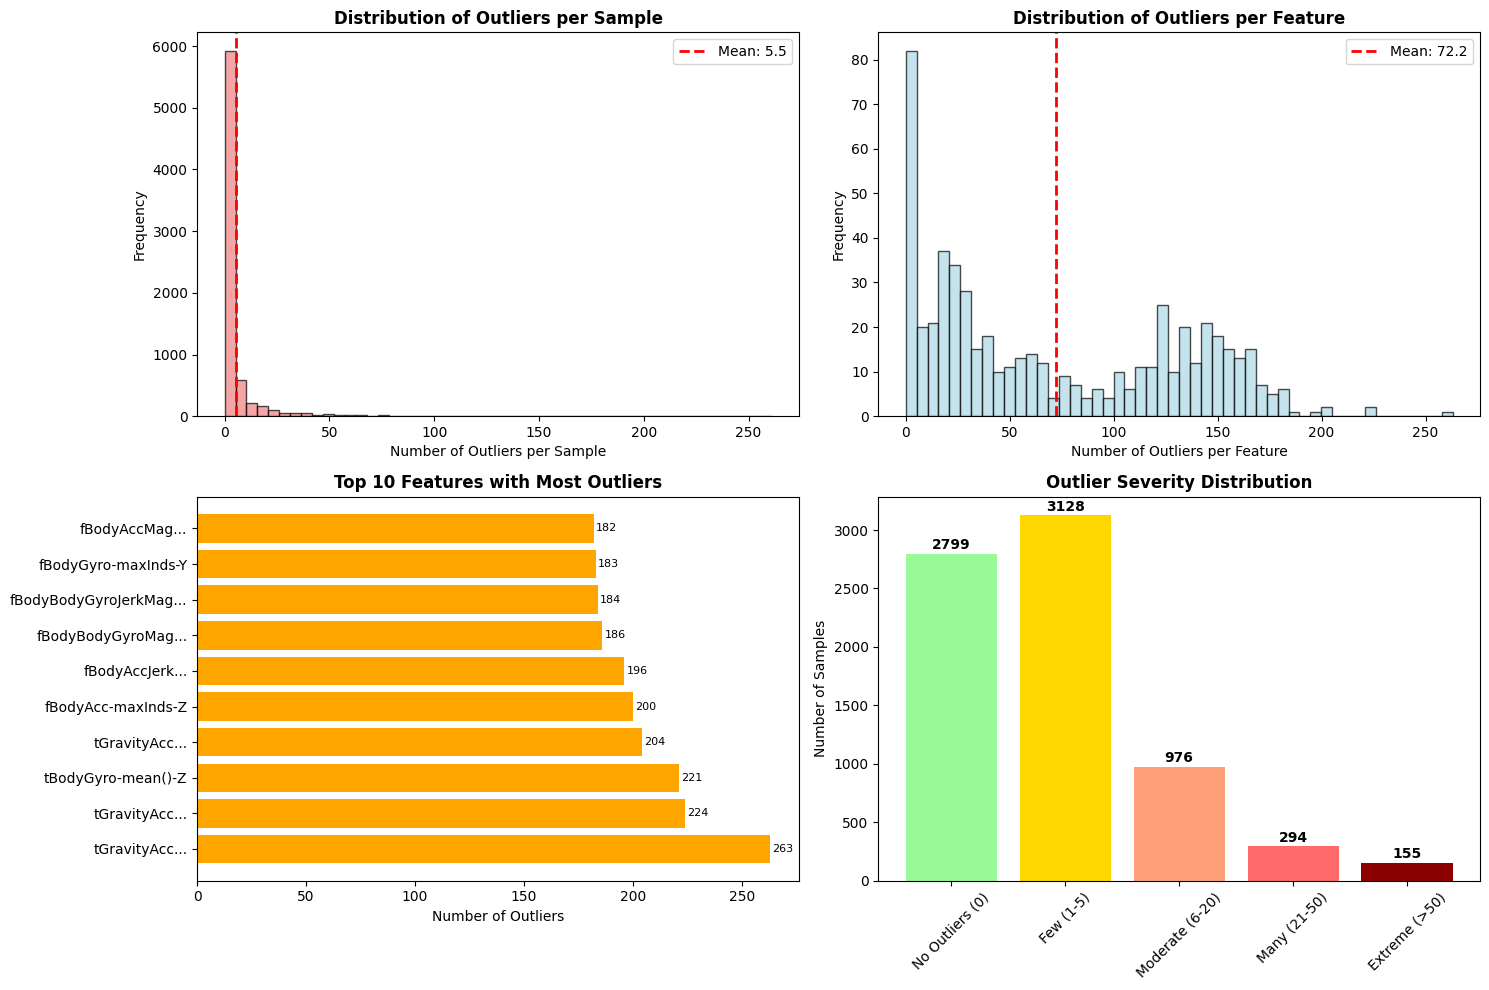


Outlier Analysis by Activity:
  LAYING: 69.7% samples with outliers
  SITTING: 41.5% samples with outliers
  STANDING: 38.1% samples with outliers
  WALKING: 74.4% samples with outliers
  WALKING_DOWNSTAIRS: 87.5% samples with outliers
  WALKING_UPSTAIRS: 69.1% samples with outliers


In [10]:
# Outlier Detection Analysis

print("=" * 60)
print("OUTLIER DETECTION ANALYSIS")
print("=" * 60)

# Calculate Z-scores for outlier detection
z_scores = np.abs(stats.zscore(X_train))
outliers_per_sample = (z_scores > 3).sum(axis=1)
outliers_per_feature = (z_scores > 3).sum(axis=0)

# Outlier statistics
samples_with_outliers = (outliers_per_sample > 0).sum()
outlier_percentage = (samples_with_outliers / len(X_train)) * 100
features_with_outliers = (outliers_per_feature > 0).sum()

print(f"Samples with outliers (Z-score > 3): {samples_with_outliers:,}")
print(f"Percentage of samples with outliers: {outlier_percentage:.1f}%")
print(f"Features with outliers: {features_with_outliers:,}")
print(f"Average outliers per sample: {outliers_per_sample.mean():.1f}")

# Visualization
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))

# Outliers per sample distribution
ax1.hist(outliers_per_sample, bins=50, alpha=0.7, color='lightcoral', edgecolor='black')
ax1.axvline(outliers_per_sample.mean(), color='red', linestyle='--', linewidth=2, 
           label=f'Mean: {outliers_per_sample.mean():.1f}')
ax1.set_title('Distribution of Outliers per Sample', fontweight='bold')
ax1.set_xlabel('Number of Outliers per Sample')
ax1.set_ylabel('Frequency')
ax1.legend()

# Outliers per feature distribution
ax2.hist(outliers_per_feature, bins=50, alpha=0.7, color='lightblue', edgecolor='black')
ax2.axvline(outliers_per_feature.mean(), color='red', linestyle='--', linewidth=2, 
           label=f'Mean: {outliers_per_feature.mean():.1f}')
ax2.set_title('Distribution of Outliers per Feature', fontweight='bold')
ax2.set_xlabel('Number of Outliers per Feature')
ax2.set_ylabel('Frequency')
ax2.legend()

# Top features with most outliers
top_outlier_features = pd.Series(outliers_per_feature, index=X_train.columns).nlargest(10)
bars = ax3.barh(range(len(top_outlier_features)), top_outlier_features.values, color='orange')
ax3.set_yticks(range(len(top_outlier_features)))
ax3.set_yticklabels([f.split('-')[0] + '...' if len(f) > 20 else f for f in top_outlier_features.index])
ax3.set_title('Top 10 Features with Most Outliers', fontweight='bold')
ax3.set_xlabel('Number of Outliers')

for i, (bar, value) in enumerate(zip(bars, top_outlier_features.values)):
    ax3.text(bar.get_width() + 1, bar.get_y() + bar.get_height()/2,
             f'{int(value)}', ha='left', va='center', fontsize=8)

# Outlier severity categories
outlier_categories = {
    'No Outliers (0)': (outliers_per_sample == 0).sum(),
    'Few (1-5)': ((outliers_per_sample >= 1) & (outliers_per_sample <= 5)).sum(),
    'Moderate (6-20)': ((outliers_per_sample >= 6) & (outliers_per_sample <= 20)).sum(),
    'Many (21-50)': ((outliers_per_sample >= 21) & (outliers_per_sample <= 50)).sum(),
    'Extreme (>50)': (outliers_per_sample > 50).sum()
}

colors = ['#98FB98', '#FFD700', '#FFA07A', '#FF6B6B', '#8B0000']
bars = ax4.bar(outlier_categories.keys(), outlier_categories.values(), color=colors)
ax4.set_title('Outlier Severity Distribution', fontweight='bold')
ax4.set_ylabel('Number of Samples')
ax4.tick_params(axis='x', rotation=45)

for bar, value in zip(bars, outlier_categories.values()):
    ax4.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 10,
             str(value), ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

# Outlier analysis by activity
print(f"\nOutlier Analysis by Activity:")
for activity in sorted(y_train.unique()):
    activity_mask = y_train == activity
    activity_outliers = outliers_per_sample[activity_mask]
    activity_outlier_pct = (activity_outliers > 0).sum() / len(activity_outliers) * 100
    print(f"  {activity}: {activity_outlier_pct:.1f}% samples with outliers")



#### Observations

- **61.9% of samples** contain at least one outlier (Z-score > 3), which is relatively common in sensor-based activity recognition datasets due to single motion variability.
- The average of **5.5 outliers per sample** suggests that outliers are distributed across multiple features rather than concentrated in a few problematic features.
- **509 out of 561 features (90.7%)** contain outliers, indicating that extreme values are widespread across the feature space rather than isolated to specific features.
- **Dynamic activities show higher outlier percentages**: WALKING_DOWNSTAIRS (87.5%), WALKING (74.4%), and WALKING_UPSTAIRS (69.1%) have more outliers than static activities.
- **Static activities have fewer outliers**: STANDING (38.1%) and SITTING (41.5%) show lower outlier rates, likely due to more stable sensor readings during stationary positions.
- The high outlier prevalence in dynamic activities is expected and represents natural variability in movement patterns, not necessarily data errors. This may actually provide valuable discriminative information for classification.


### PCA Visualisation

Principal Component Analysis (PCA) is a dimensionality reduction technique that projects high-dimensional data onto a lower-dimensional space while preserving the maximum variance. This visualization complements the correlation analysis by demonstrating how dimensionality reduction can help manage the high correlation and feature redundancy identified earlier.

This analysis:
1. Projects the **561-dimensional feature space** onto **2 principal components** that capture the most variance in the data.
2. Creates a scatter plot colored by activity labels to examine class separability in the reduced space.
3. Helps identify whether activities form distinct clusters or overlap significantly in the reduced space.

While a 2D projection may not capture all the discriminative information (some variance is lost), it offers insights into the inherent structure of the data and the potential difficulty of classification tasks. Well-separated clusters suggest that the activities are distinguishable, while overlapping clusters may indicate similar motion patterns or the need for more sophisticated models. This visualization is exploratory and helps assess the feasibility of dimensionality reduction as a preprocessing step.


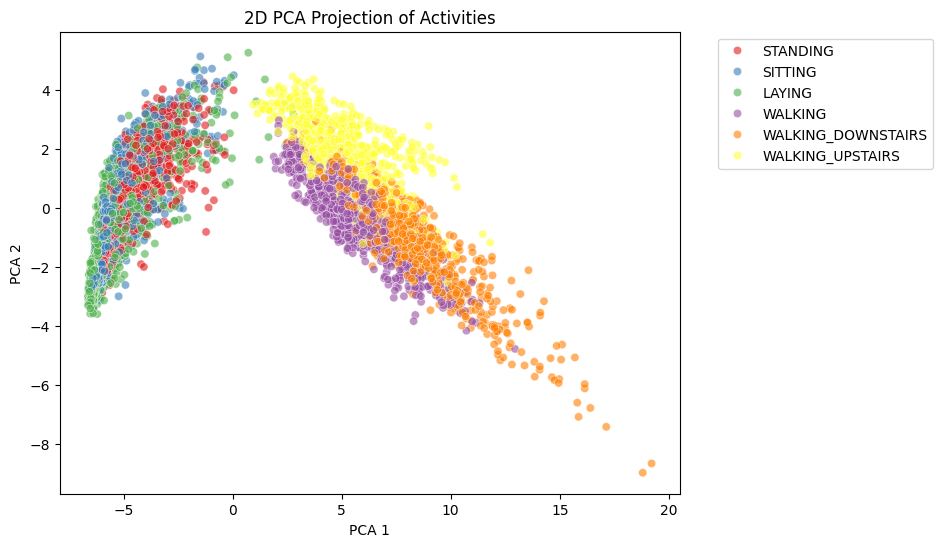

In [11]:
# Principal Component Analysis
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_train)

plt.figure(figsize=(8,6))
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=y_train, palette="Set1", alpha=0.6)
plt.title("2D PCA Projection of Activities")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

#### Observations

- The 2D PCA projection reveals **discernible clusters** for different activities, though some **overlap** is present, particularly between similar activities like SITTING and STANDING. This overlap is expected given their similar static nature, where both activities involve minimal body movement, making them difficult to distinguish based solely on motion features.
- **Dynamic activities** (WALKING, WALKING_UPSTAIRS, WALKING_DOWNSTAIRS) tend to form **more distinct, separated clusters** in the PCA space, indicating that motion-based features effectively capture the unique movement patterns characterizing these activities. This suggests that accelerometer and gyroscope data successfully encode discriminative information for dynamic motions.
- The visualization suggests that while a 2D representation captures some underlying structure (likely the first two principal components explain a portion of the total variance), the **full 561-dimensional space likely contains significantly more discriminative information** that is not visible in this 2D projection. Most variance and class separation information exists in higher-dimensional components.
- The presence of class overlap, especially between static activities, indicates that a **non-linear classifier** or **more sophisticated model architecture** (e.g., Random Forest, Gradient Boosting, or Neural Networks) may be necessary to achieve high accuracy, as linear separation in 2D PCA space does not guarantee linear separability in the original high-dimensional feature space.
- The **spread and variability** within each activity cluster reflects the natural variability in how different individuals perform the same activity, supporting the need for robust models that can generalize across subjects with different movement patterns, body types, and personal styles.
- While this 2D visualization provides useful exploratory insights, **dimensionality reduction to only 2 components likely discards substantial discriminative information**. For actual modeling, retaining more principal components (e.g., enough to capture 80-95% of variance) or using the original feature space would be more appropriate for achieving high classification accuracy.